### If the customer has defaulted assigning last statement target value to 1 & others to 0

In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

In [2]:
# Read training data 
df_train_x = pd.read_parquet('D:/Sakshi/DSBA_6156_SERJ/data/train.parquet')
df_train_x.columns = df_train_x.columns.str.lower()
# Read training data labels
df_train_y = pd.read_csv('D:/Sakshi/DSBA_6156_SERJ/data/train_labels.csv')
df_train_y.columns = df_train_y.columns.str.lower()
df_train_y = df_train_y.set_index('customer_id')

df_train_x = df_train_x.sort_values(['customer_id', 's_2'])
df_train = pd.merge(df_train_x, df_train_y, on='customer_id')
del(df_train_x, df_train_y)

In [18]:
# Before doing any transformation see the datatypes of the features
df_train.dtypes.to_csv('../ignore/final/before_transformations.csv')

In [3]:
df_train['last_statement_flag'] = (df_train.groupby('customer_id')['s_2']
                      .rank(method='dense', ascending=False)
                      .astype(int)
                   )
df_train['last_statement_target'] = df_train['target']*df_train['last_statement_flag']\
   .apply(lambda x: 1 if x==1 else 0)                 

In [4]:
df_train[df_train['customer_id']== '0000f99513770170a1aba690daeeb8a96da4a39f11fc27da5c30a79db61c1e85']\
    [['customer_id','s_2','target','last_statement_flag','last_statement_target']]

,customer_id,s_2,target,last_statement_flag,last_statement_target
104,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-03-15,1,13,0
105,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-04-14,1,12,0
106,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-05-15,1,11,0
107,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-06-14,1,10,0
108,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-07-15,1,9,0
109,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-08-15,1,8,0
110,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-09-14,1,7,0
111,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-10-14,1,6,0
112,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-11-14,1,5,0
113,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2017-12-17,1,4,0


In [5]:
pipeline = Pipeline(steps=[])
# 89% of d_66 column values were missing, but it has been filled with -1 while parquet generation.
# Also assign the column names in sequence in which it appars in the file  
categorical_cols = ['d_63', 'd_64', 'd_66', 'd_68', 'b_30', 'b_31', 'b_38', 'd_114', 'd_116',
                     'd_117', 'd_120', 'd_126']
df_train[categorical_cols].isnull().sum() / len(df_train)

d_63     0.0
d_64     0.0
d_66     0.0
d_68     0.0
b_30     0.0
b_31     0.0
b_38     0.0
d_114    0.0
d_116    0.0
d_117    0.0
d_120    0.0
d_126    0.0
dtype: float64

In [22]:
# # Check the percentage of missing values
# null_series = df_train.isna().sum() / df_train.shape[0]
# null_series.to_csv('../ignore/final/column_null_values_prop.csv')
# del null_series

In [6]:
# Check for the unique values for all the categorical features
for i in categorical_cols:
    print(f'The unique values for column {i} is {df_train[i].unique()}')

The unique values for column d_63 is [0 3 4 1 2 5]
The unique values for column d_64 is [ 0  2 -1  3  1]
The unique values for column d_66 is [-1  1  0]
The unique values for column d_68 is [ 6  2  3 -1  5  4  0  1]
The unique values for column b_30 is [ 0  2  1 -1]
The unique values for column b_31 is [1 0]
The unique values for column b_38 is [ 2  1  3  5  6  7  4 -1]
The unique values for column d_114 is [ 1  0 -1]
The unique values for column d_116 is [ 0 -1  1]
The unique values for column d_117 is [ 5  0  7  3  2 -1  4  6]
The unique values for column d_120 is [ 0  1 -1]
The unique values for column d_126 is [ 2 -1  1  0]


In [7]:
print(f'The shape of the original file is:{df_train.shape}')

The shape of the original file is:(5531451, 193)


https://towardsdatascience.com/pipelines-custom-transformers-in-scikit-learn-the-step-by-step-guide-with-python-code-4a7d9b068156

In [8]:
class PreProcessing(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_cols):
        self.categorical_cols = categorical_cols

    def fit(self, X, y=None):
        # Get the list of columns that have missing values greater than equal to 40%
        missing_perc = round((X.isnull().sum() / len(X)) * 100, 2)
        # Prepare final List of columns to drop
        self.cols_to_drop = missing_perc[missing_perc.ge(40)].index.tolist() + ['last_statement_flag' , 'target']

        return self

    def transform(self, X):
        numeric_cols = list(set(X.columns.tolist(
        )) - set(self.categorical_cols + self.cols_to_drop + ['last_statement_target', 'customer_id', 's_2']))

        # Impute the mean of the numeric columns
        for col in numeric_cols:
            # Check if the column has any null value, then only apply the imputation
            if X[col].isnull().any():
                X[col] = X[col].fillna(X[col].mean())
                            
            # Scale
            mean = X[col].mean()
            std = X[col].std()
            if std > 0:
                X[col] = ((X[col] - mean) / std).astype('float32')

        X = X.drop(columns = self.cols_to_drop)

        return X

# use all the statements of a customer where all stmts are marked with the same target value
preprocessing = PreProcessing(categorical_cols)
df_processed = preprocessing.fit_transform(df_train)

pipeline.steps.append(('preprocessing', preprocessing))

In [9]:
del (df_train)
print(f'After processing the shape is :{df_processed.shape}')

After processing the shape is :(5531451, 173)


In [27]:
# Check the correlation for the numeric columns
df_corr = df_processed.drop(columns = categorical_cols + ['target','customer_id','s_2']).corr()
df_corr.to_csv("../ignore/final/num_corr_results.csv")

In [28]:
from sklearn.linear_model import LinearRegression

def sklearn_vif(data):

    # initialize dictionaries
    result = {}

    # form input data for each exogenous variable
    exogs = data.columns.to_list()
    for exog in exogs:
        # print(exog)
        not_exog = [i for i in exogs if i != exog]
        # exog would be for which the VIF has to be calculated based on the combination of other columns
        X, y = data[not_exog], data[exog]  
        # extract r-squared from the fit
        r_squared = LinearRegression(n_jobs=12).fit(X, y).score(X, y)

        # calculate VIF
        vif = 1/(1 - r_squared)
        result[exog] = vif
    return result

vif_data1 = sklearn_vif(df_processed.drop(columns = categorical_cols + ['target','customer_id','s_2']))
# Convert the results from the dictionary to dataframe
df_vif = pd.DataFrame({
    'feature': vif_data1.keys(),
    'VIF': vif_data1.values()
})
del(vif_data1)
df_vif.to_csv("../ignore/final/num_VIF_data_results.csv",index=False)

In [10]:
df_vif = pd.read_csv("D:/Sakshi/DSBA_6156_SERJ/ignore/final/num_VIF_data_results.csv")

In [11]:
# Plainly drop all the columns with higher VIF values
df_processed.drop(columns = df_vif[df_vif['VIF']> 10]['feature'].to_list(), inplace=True)
print(f'The remaining columns of the data after dropping columns with high VIF : {df_processed.shape[1]}')

The remaining columns of the data after dropping columns with high VIF : 143


In [12]:
X, y = df_processed.drop(columns=['last_statement_target','customer_id','s_2']),\
                             df_processed['last_statement_target']
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2, random_state=2303, stratify = y)                                                 

In [13]:
# Model
sm_logit1 = sm.Logit(y_train,X_train).fit()
print(sm_logit1.summary())

Optimization terminated successfully.
         Current function value: 0.078139
         Iterations 12
                             Logit Regression Results                            
Dep. Variable:     last_statement_target   No. Observations:              4425160
Model:                             Logit   Df Residuals:                  4425020
Method:                              MLE   Df Model:                          139
Date:                   Tue, 13 Dec 2022   Pseudo R-squ.:                  0.2469
Time:                           22:25:57   Log-Likelihood:            -3.4578e+05
converged:                          True   LL-Null:                   -4.5912e+05
Covariance Type:               nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p_2           -0.3997      0.008    -52.626      0.000      -0.415      -0.385
d_39

In [14]:
del(df_processed)
# Remove the insignificant features and train the model again. I will keep the alpha level as 0.05
logit_pvalues = round(sm_logit1.pvalues,3)
high_pval_col = logit_pvalues.index[logit_pvalues > 0.05]

# Drop these columns
X = X.drop(columns = high_pval_col)
print(f'The columns remaining after removing insignificant ones : {X.shape}')
X_train, X_test,y_train, y_test= train_test_split(X, y, test_size=0.2,
                                                     random_state=2303, stratify = y)

# Model
sm_logit2 = sm.Logit(y_train,X_train).fit()
print(sm_logit2.summary())

The columns remaining after removing insignificant ones : (5531451, 119)
Optimization terminated successfully.
         Current function value: 0.078142
         Iterations 13
                             Logit Regression Results                            
Dep. Variable:     last_statement_target   No. Observations:              4425160
Model:                             Logit   Df Residuals:                  4425041
Method:                              MLE   Df Model:                          118
Date:                   Tue, 13 Dec 2022   Pseudo R-squ.:                  0.2468
Time:                           22:29:22   Log-Likelihood:            -3.4579e+05
converged:                          True   LL-Null:                   -4.5912e+05
Covariance Type:               nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p_2       

In [15]:
# Calculate the confusion matrix
prediction_probab = sm_logit2.predict(X_test)
prediction = list(map(round,prediction_probab))
confusion_matrix(y_test,prediction)

array([[1081056,    1469],
       [  22611,    1155]], dtype=int64)

Validation accuracy is: 0.9782335750720199
Logistic : ROC AUC = 0.893


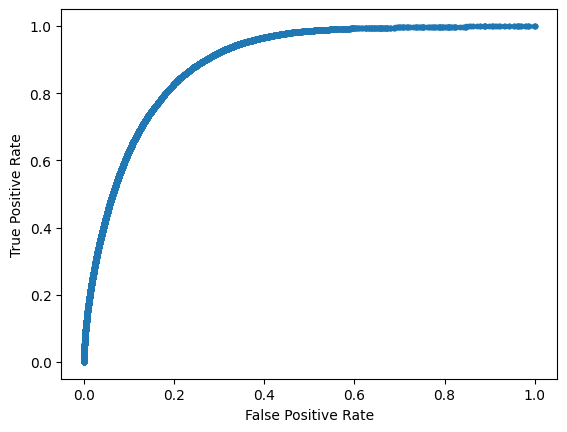

In [16]:
print(f'Validation accuracy is: {accuracy_score(y_test, prediction)}')

# Calculate roc metric 
print('Logistic : ROC AUC = %.3f' % (roc_auc_score(y_test,prediction_probab)))

fpr,tpr,_ = roc_curve(y_test,prediction_probab)
plt.plot(fpr,tpr,marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [17]:
# Clear the memory before loading the test data to predict
del(fpr,tpr,X_test,X_train,y_test,y_train,X,y,prediction,prediction_probab)

In [18]:
def execute_model(df):
    # Just add extra columns with 0 value so that pipeline does not fail --> these are the extra columns that we had in the training data
    extra_cols = ['target','last_statement_flag','last_statement_target']
    # Concatenate the dataframe of extra columns with the dataframe of the test data
    df = pd.concat([
        df,
        pd.DataFrame(np.zeros((df.shape[0], len(extra_cols))), columns=extra_cols)
    ], axis=1)

    # Use the pipeline to transform
    X = pipeline.transform(df)

    # Drop target & the insignificant variables found during the training using statsmodel p-value
    X.drop(columns=['last_statement_target','customer_id','s_2'] + df_vif[df_vif['VIF']> 10]['feature'].to_list()
                    + high_pval_col.tolist(), inplace=True)

    # return log_reg.predict(X), log_reg.predict_proba(X)
    # In the statsmodel predict will give the probability
    return list(map(round,sm_logit2.predict(X))), sm_logit2.predict(X).tolist()
    

In [19]:
del(sm_logit1)
df_test = pd.read_parquet('D:/Sakshi/DSBA_6156_SERJ/data/test.parquet')
df_test.columns= df_test.columns.str.lower()
# Define the result mdf
mdf = pd.DataFrame(columns=['customer_id', 's_2', 'pred', 'proba'])
y, y_proba = execute_model(df_test)

mdf = pd.concat([
    mdf,
    pd.DataFrame({
        'customer_id': df_test['customer_id'].values,
        's_2': df_test['s_2'].values,
        'pred': y,
        'proba': y_proba
    })
]) 
# mdf.to_csv('../ignore/final/logisticregression_baseline_prediction.csv', index=False)

In [20]:
mdf['s_2'] = pd.to_datetime(mdf['s_2'])
mdf['s_2'].dtype

dtype('<M8[ns]')

## Just take the last statement probability of each customer

In [21]:
# Get the last statement probability of each of the customer
df_result_last = mdf.sort_values(by = 's_2').groupby('customer_id')[['customer_id','proba']].tail(1)
df_result_last.rename(columns= {'proba' : 'prediction'},inplace=True)
df_result_last.head()
df_result_last.to_csv('D:/Sakshi/DSBA_6156_SERJ/ignore/ppt_analysis/logistic_baseline1_laststmt_submission.csv', index=False)

#### Weighted probabilities using Joe's Code (test data) for the last 3 stmts

In [22]:
# Defining the outcome weighting.

def conditions(x):
    # Customer has 3 statements:
    if   x == 3:   return 0.1
    elif x == 6:   return 0.15
    elif x == 9:   return 0.75
    
    # Customer has 2 statements:
    elif x == 2:   return 0.2
    elif x == 4:   return 0.8
    
    # Customer has 1 statement:
    elif x == 1:   return 1.0 
    else:          return "error"

In [23]:
# Take the last 3 statements of each customer
mdf1 = mdf.sort_values('s_2').groupby('customer_id').tail(3)
# if the customer has last 3 stmts the ranking will be as - 1st to the older stmt and 3rd rank to the latest stmt. 
mdf1["statement_num"] = mdf1.groupby("customer_id")["s_2"].rank(method="first", ascending=True)
# The statement_count variable will give the count of the statements for each customer (i.e. to know if they have all the 3 or less than that)
mdf1['statement_count'] = mdf1.groupby('customer_id')['statement_num'].transform('max')

# Create a number so we can handle the case where a customer had only 1 or 2 statements. 
# Multiplied to give me a unique value for each case. See conditions() above.
mdf1['statement_checksum'] = (mdf1['statement_count']) * mdf1['statement_num']

# Assign the weights to the statements
mdf1['statement_weight'] = mdf1['statement_checksum'].apply(conditions)

# Calculating the weighted sum
mdf1 ['prediction'] = mdf1['proba'] * mdf1['statement_weight']

mdf1 = mdf1[['customer_id', 'prediction']]

# Grouping those weighted sums by customer_id to give granularity of 1 proba per customer
mdf1 = mdf1.groupby('customer_id').sum()
# Bring the customer_id from index to column
mdf1.reset_index(inplace=True)
# Send the data to the file
mdf1.to_csv('D:/Sakshi/DSBA_6156_SERJ/ignore/ppt_analysis/logistic_baseline1_weighted_last3_sub.csv', index=False)